### Employee Attrition using **CatBoost**

* L.S, ottobre 2021
* gestione delle **feature categoriche**
* importanza del **Learning rate**
* gestione dataset imbalance tramite **class weights**
* expanded list of features (see eda2)

Questo notebook è semplificato, rispetto alla versione completa (catboost1)

In [1]:
import pandas as pd
import numpy as np

# for reading data from Object Storage
import ocifs
from ads import set_auth

# usero' catboost
import catboost as cat

# per la confusion matrix ed altre metriche uso sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

# grafici
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# this way we enable access to Object Storage and don't need to provide API keys
# OCI admin must have set-up a dynamic group for Notebooks, with proper policy
set_auth(auth='resource_principal')

In [3]:
# utility function and globals
# GLOBALS
FIGSIZE = (9, 6)

SEED = 42

# additional print
DEBUG = 0

#set the tracking uri to log runs on a tracking server
TRACKING_URI = "http://150.230.146.100:5000/"

# end globals

#
# Utility functions
#

#
# easy plot of the confusion matrix
#
def plot_cm(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();

#
# Compute metrics
#
def compute_auc(model, x_test, y_test):
    y_pred = model.predict_proba(x_test)
    y_pred = y_pred[:, 1]
    auc = round(roc_auc_score(y_test, y_pred), 4)
    
    return auc

def compute_prec_rec(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    
    rec = round(recall_score(y_test, y_pred_labels), 4)
    prec = round(precision_score(y_test, y_pred_labels), 4)
    
    return prec, rec

def compute_accuracy(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred_labels)
    
    return round(acc, 3)

#
# my split in train, test set
#
def my_train_test_split(df, frac):
    # frac: the fraction used for train
    # df: the dataframe
    
    # shuffle before split
    df = df.sample(frac=1., random_state=SEED)

    # FRAC = 0.90
    tot_rec = df.shape[0]
    NUM_TRAIN = int(frac*tot_rec)
    NUM_TEST = tot_rec - NUM_TRAIN

    data_train = df[:NUM_TRAIN]
    data_test = df[NUM_TRAIN:]

    print()
    print('Numero totale di campioni:', tot_rec)
    print('Numero di campioni nel TRAIN SET:', data_train.shape[0])
    print('Numero di campioni nel TEST SET:', data_test.shape[0])
    
    return data_train, data_test

# read the csv from Object storage and return a pandas df
def read_from_object_storage(prefix, file_name):
    # get access to OSS as an fs
    # config={} assume resource_principal auth
    fs = ocifs.OCIFileSystem(config={})
    
    FILE_PATH = prefix + file_name
    
    # reading data from Object Storage
    with fs.open(FILE_PATH, 'rb') as f:
        df = pd.read_csv(f)
    
    return df

### Reading dataset from Object Storage

In [4]:
# input data from file in Object Storage
PREFIX = "oci://data_input@fr95jjtqbdhh/"
FILE_NAME = "orcl_attrition.csv"

# see in functions above
data_orig = read_from_object_storage(prefix=PREFIX, file_name=FILE_NAME)

# some columns are not needed. This is the list of columns that will be used
my_columns = ['Age', 'Attrition','CommuteLength','EducationField','EducationalLevel','EnvironmentSatisfaction',
              'Gender','HourlyRate','JobFunction','JobInvolvement','JobRole','JobSatisfaction','MaritalStatus',
              'MonthlyIncome','MonthlyRate','NumCompaniesWorked','OverTime','PerformanceRating','RelationshipSatisfaction',
              'SalaryLevel','StockOptionLevel','TrainingTimesLastYear','TravelForWork','WorkLifeBalance','YearsAtCurrentLevel','YearsSinceLastPromotion']

# dataset filtrato eliminando le colonne non necessarie
data = data_orig[my_columns]

In [6]:
# tipologie di features e colonne
TARGET = 'Attrition'

# automatizziamo !!!
all_columns = sorted(data.columns)
features = sorted(list(set(all_columns) - set([TARGET])))

# per decidere, guarda statistiche dal Notebook EDA1
cat_columns = sorted(['Age', 'Attrition','CommuteLength','EducationField','EducationalLevel','EnvironmentSatisfaction',
              'Gender','HourlyRate','JobFunction','JobInvolvement','JobRole','JobSatisfaction','MaritalStatus',
                      'NumCompaniesWorked','OverTime','PerformanceRating','RelationshipSatisfaction',
                      'StockOptionLevel','TrainingTimesLastYear','TravelForWork','WorkLifeBalance','YearsAtCurrentLevel','YearsSinceLastPromotion'])


# colonne numeriche, continue (tutte le altre)
num_columns = sorted(list(set(all_columns) - set(cat_columns) - set([TARGET])))

print('Colonna Target:', TARGET)
print()
print('Tutte le features:', features, len(features))
print()
print('Colonne categorical:', cat_columns, len(cat_columns))
print()
print('Colonne numeriche:', num_columns, len(num_columns))


# split TRAIN, TEST
# shuffle prima dello split TRAIN, TEST
FRAC = 0.90

data_train, data_test = my_train_test_split(data, frac=FRAC)

Colonna Target: Attrition

Tutte le features: ['Age', 'CommuteLength', 'EducationField', 'EducationalLevel', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobFunction', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'SalaryLevel', 'StockOptionLevel', 'TrainingTimesLastYear', 'TravelForWork', 'WorkLifeBalance', 'YearsAtCurrentLevel', 'YearsSinceLastPromotion'] 25

Colonne categorical: ['Age', 'Attrition', 'CommuteLength', 'EducationField', 'EducationalLevel', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobFunction', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'NumCompaniesWorked', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'TravelForWork', 'WorkLifeBalance', 'YearsAtCurrentLevel', 'YearsSinceLastPromotion'] 23

Colonne numeriche: ['MonthlyIncome', 'MonthlyRate

In [7]:
# separo X (features) ed y (target)
x_train = data_train[features]
y_train = data_train[TARGET]

x_test = data_test[features]
y_test = data_test[TARGET]

# encode labels as 0, 1
le = LabelEncoder()

# fit the encoder
le.fit(y_train.values)

# encode train and test
y_train = le.transform(y_train.values)
y_test = le.transform(y_test.values)

# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(x_train.columns) if col in cat_columns]

### First run, without class weights

In [8]:
%%time
# First: try without addressing data imbalance

params = {'iterations':900,
          'learning_rate':0.005,
          'depth':10
         }

model = cat.CatBoostClassifier()
model.set_params(**params)

model.fit(x_train, y_train, cat_columns_idxs, verbose=False, early_stopping_rounds=30)

CPU times: user 4min 10s, sys: 42.2 s, total: 4min 53s
Wall time: 16.5 s


In [9]:
# compute and register results
auc = compute_auc(model, x_test, y_test)
print('AUC computed on the test set is:', auc)

prec, rec = compute_prec_rec(model, x_test, y_test)
print('precision and recall computed on the test set are:', 'prec:', prec, 'rec:', rec)

acc = compute_accuracy(model, x_test, y_test)
print('Accuracy on test set is:', acc)

AUC computed on the test set is: 0.8534
precision and recall computed on the test set are: prec: 0.7143 rec: 0.1852
Accuracy on test set is: 0.837


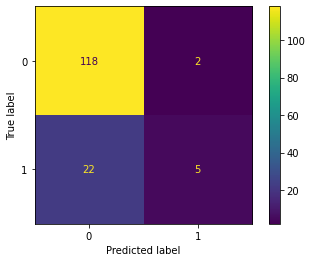

In [10]:
plot_cm(model, x_test, y_test)

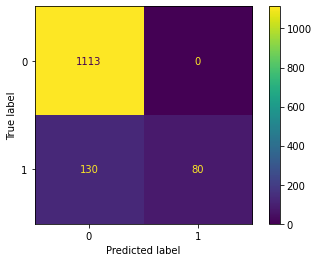

In [11]:
plot_cm(model, x_train, y_train)

### Second run, with class weights

In [12]:
%%time

# to address data imbalance
class_weights = dict({0:1, 1:5.5})

params = {'iterations':900,
          'learning_rate':0.005,
          'depth':10,
          'class_weights':class_weights
         }

model = cat.CatBoostClassifier()
model.set_params(**params)

model.fit(x_train, y_train, cat_columns_idxs, verbose=False, early_stopping_rounds=30)

CPU times: user 4min 9s, sys: 41.2 s, total: 4min 50s
Wall time: 16.1 s


In [13]:
# compute and register results
auc = compute_auc(model, x_test, y_test)
print('AUC computed on the test set is:', auc)

prec, rec = compute_prec_rec(model, x_test, y_test)
print('precision and recall computed on the test set are:', 'prec:', prec, 'rec:', rec)

acc = compute_accuracy(model, x_test, y_test)
print('Accuracy on test set is:', acc)

AUC computed on the test set is: 0.8485
precision and recall computed on the test set are: prec: 0.5769 rec: 0.5556
Accuracy on test set is: 0.844


### Evaluate confusion matrix on test set

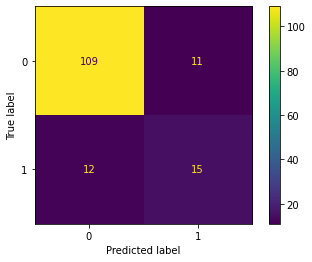

In [14]:
plot_cm(model, x_test, y_test)

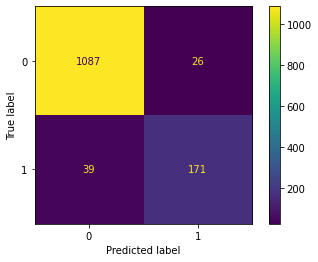

In [15]:
# c'è un certo overfitting...
plot_cm(model, x_train, y_train)

In [17]:
# aggiunta di altre feature ha leggermente peggiorato l'overfitting... ci vuole l2 reg.
# però:recall è eguale, accuracy leggermente migliore... quindi bene aggiungere altre feature

### Global explaination using feature importance

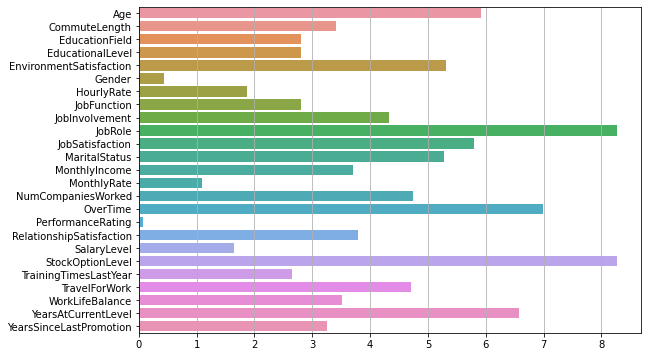

In [16]:
# eXplainability: Feature importance

plt.figure(figsize = FIGSIZE)
plt.grid(True)
sns.barplot(x = model.get_feature_importance(), y = features);

In [19]:
%%time

# let's check with the expnaded set of features + L2 reg

# to address data imbalance
class_weights = dict({0:1, 1:5.5})

params = {'iterations':900,
          'learning_rate':0.005,
          'depth':6,
          'class_weights':class_weights,
          'l2_leaf_reg':1.4775889527824428
         }

model = cat.CatBoostClassifier()
model.set_params(**params)

model.fit(x_train, y_train, cat_columns_idxs, verbose=False, early_stopping_rounds=30)

CPU times: user 1min 33s, sys: 30.4 s, total: 2min 4s
Wall time: 7.53 s


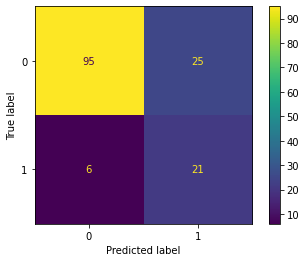

In [20]:
plot_cm(model, x_test, y_test)

In [21]:
# compute and register results
auc = compute_auc(model, x_test, y_test)
print('AUC computed on the test set is:', auc)

prec, rec = compute_prec_rec(model, x_test, y_test)
print('precision and recall computed on the test set are:', 'prec:', prec, 'rec:', rec)

acc = compute_accuracy(model, x_test, y_test)
print('Accuracy on test set is:', acc)

AUC computed on the test set is: 0.8552
precision and recall computed on the test set are: prec: 0.4565 rec: 0.7778
Accuracy on test set is: 0.789
